# I- Importing Modules:

In [ ]:
#Install the required modules
!pip install gensim spacy nltk
!pip install vec2graph
!pip install python-bidi
!pip install arabic-reshaper
!pip install patool

# Download a model
!wget "https://bakrianoo.s3-us-west-2.amazonaws.com/aravec/full_grams_cbow_300_wiki.zip"
!unzip "full_grams_cbow_300_wiki.zip"

# Importing Libraries
import nltk
import gensim
from gensim.models import FastText
import re
import spacy
import numpy as np
import operator
import pandas as pd
from sklearn.decomposition import PCA
from bidi.algorithm import get_display
import arabic_reshaper
import patoolib
%matplotlib inline
from matplotlib import pyplot as plt
nltk.download('punkt')
nltk.download("stopwords")
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))

In [ ]:
# Importing Files

from google.colab import files
uploaded = files.upload()

Saving arabiccc.txt to arabiccc.txt


# II- Text Preprocessing:

In [ ]:
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    text = " ".join([w for w in text.split(" ") if not w in arb_stopwords])
    
    text = text.strip()

    return text

# III- AraVec Model:

In [ ]:
# load the AraVec model
model = gensim.models.Word2Vec.load("full_grams_cbow_300_wiki.mdl")
print("We've",len(model.wv.index2word),"vocabularies")
# Export the Word2Vec format + gzip it. make a directory called "spacyModel"
%mkdir spacyModel
# export the word2vec fomart to the directory
model.wv.save_word2vec_format("./spacyModel/aravec.txt")
# using `gzip` to compress the .txt file
!gzip ./spacyModel/aravec.txt

#Initialize the spaCy model using AraVec vectors
#This will create a folder called /spacy.aravec.model within your current working directory
!python -m spacy  init-model ar spacy.aravec.model --vectors-loc ./spacyModel/aravec.txt.gz

We've 662109 vocabularies
✔ Successfully created model
662109it [01:17, 8582.36it/s]
✔ Loaded vectors from spacyModel/aravec.txt.gz
✔ Sucessfully compiled vocab
662298 entries, 662109 vectors


In [ ]:
model.wv.index2word[:20]

['.',
 'في',
 'من',
 'علي',
 '(',
 ')',
 'الي',
 'ان',
 'و',
 'عام',
 ':',
 'التي',
 'او',
 ',',
 'كان',
 'مع',
 'هو',
 'عن',
 'هذه',
 'الذي']

In [ ]:
# load AraVec Spacy model
nlp = spacy.load("./spacy.aravec.model/")
# Define the preprocessing Class
class Preprocessor:
    def __init__(self, tokenizer, **cfg):
        self.tokenizer = tokenizer

    def __call__(self, text):
        preprocessed = clean_str(text)
        return self.tokenizer(preprocessed)
# Apply the `Preprocessor` Class
nlp.tokenizer = Preprocessor(nlp.tokenizer)

## Error Detection (with vectors):

In [ ]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    plt.figure(figsize=(10,7))
    plt.scatter(twodim[:,0]+1, twodim[:,1]-0.1, edgecolors='none', c='purple')
    
    for word, (x,y) in zip(words, twodim):
      reshaped_text = arabic_reshaper.reshape(u''.join(word))
      artext = get_display(reshaped_text)
      plt.text(x+0.02, y+0.1, artext ,fontsize=20)

In [ ]:
# sort of a dictionary descendently by its values 
def desc_sort_dict(d): 
  return sorted(d.items(),key=operator.itemgetter(1),reverse=True)

In [ ]:
# create a dictionary based on splitted input text
def create_dictionary(input_text):
  # split text into tokens 
  tokens = np.array(input_text.split(" "))
  #create empty dictionary
  dictionary = {}
  # loop through tokens 
  for token in tokens: 
    token_vector = np.array(nlp(token).vector)  # extract vector and transform into np.array() so that we can sum it later
    sum_vec = np.sum(token_vector)  # sum the vales of the vector for the current token 
    dictionary[token] = abs(sum_vec)  # fill the dictionary by token as key and summed vector as value
  return dictionary  # return the dictionary

In [ ]:
# return the distance between the most far word and the phrase global context center
def get_distance_value(ordered_tuple):
  # ordered_tuple is the sorted dictionary of summed distances
  d = ordered_tuple
  print(d)
  err = d[0][1]  # value summed the wrong word
  s=0
  for i in range(1,len(d)):
    s+=d[i][1]
  corpus_center = s/(len(d))  
  res = err - corpus_center# difference between the first elemnt of the dictionary and the global context
  return res 

In [ ]:
# get a decision whether the most far word is error or not
def detect(input,seuil,visualization=False):
  print(input)
  input = clean_str(input)
  # create dictionary of tokens as keys and corresponding summed vector as values , sorted in descending order based on values
  dictio = create_dictionary(input)
  # sort the dictionary
  d = desc_sort_dict(dictio)
  # calculate the distance
  distance =  get_distance_value(d)

  errors=list()
  for i in range(0,len(d)):
    d1=list(d)
    d1.remove(d1[i])

    s=0
    for j in range(0,len(d1)):
      s+=d1[j][1]
    corpus_center = s/(len(d1))
    errors.append(d[i][1]-corpus_center)
  
  ind=errors.index(max(errors))
  word = d[ind][0]

  if errors[ind] >= seuil:
    print("Decision : ",word," is detected as a wrong word")
  else :
    print("Decision : ",word," is not considered as wrong word")
  
    # visualization
  if visualization==True:
    display_pca_scatterplot(model, [clean_str(i) for i in input.split(" ")])

  return word


إصطاد الصياد سكة
[('سكه', 5.200851), ('اصطاد', 2.7276487), ('الصياد', 0.23392582)]
Decision :  سكه  is detected as a wrong word


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


'سكه'

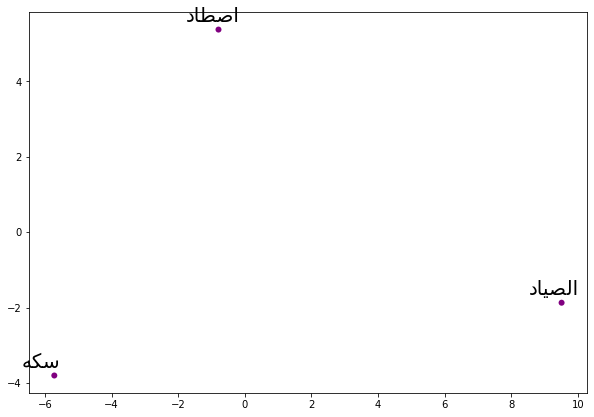

In [ ]:
# get the input text
text =  "إصطاد الصياد سكة"

# detect errory given the input text and the amount (for the decision) 
detect(text,2,True)

In [ ]:
# Reading DataSet
df = pd.read_csv('arabiccc.txt',sep="\n")
df.columns = ['text']
df.head()

,text
0,القَمْل|الفَلاح يَحْصد القَمْل
1,الفرس|الوَلد يَكْتُب الفرسَ
2,فداء|أَلْعَبُ فى فداء الْمَدْرَسَة
3,الاشرار|اقبلت بجد اسقيها اروي الاشرار احييها
4,معدة|الحياة بسيطة حقا ، لكننا نصر على جعلها معدة


In [ ]:
df['Label'] = df['text'].apply(lambda x: x.split("|")[0] )
df['text'] = df['text'].apply(lambda x: x.split("|")[1] )
df.head()

,text,Label
0,الفَلاح يَحْصد القَمْل,القَمْل
1,الوَلد يَكْتُب الفرسَ,الفرس
2,أَلْعَبُ فى فداء الْمَدْرَسَة,فداء
3,اقبلت بجد اسقيها اروي الاشرار احييها,الاشرار
4,الحياة بسيطة حقا ، لكننا نصر على جعلها معدة,معدة


In [ ]:
df['aravec'] = df['text'].apply(lambda x:detect(x, 2)  )

In [ ]:
df.head()

,text,Label,aravec
0,الفَلاح يَحْصد القَمْل,القَمْل,الفلاح
1,الوَلد يَكْتُب الفرسَ,الفرس,الفرس
2,أَلْعَبُ فى فداء الْمَدْرَسَة,فداء,المدرسه
3,اقبلت بجد اسقيها اروي الاشرار احييها,الاشرار,الاشرار
4,الحياة بسيطة حقا ، لكننا نصر على جعلها معدة,معدة,جعلها


# IV- Model Evaluation:

In [ ]:
# Precision and Recall Calculation

true=0
false=0
c=0
for i,j in zip(df['Label'],df['aravec']):
  c+=1
  if i == j:
    true+=1
  else:
    false+=1
print("Precision: ",true/c)
print("Recall: ",true/false)

Precision:  0.2916666666666667
Recall:  0.4117647058823529
